In [1]:
__author__ = 'Derek Qi'
# Doing portfolio backtest and generates output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from factor_mining.combine_factors import *
from factor_mining.factor_model_regression import *
from factor_mining.factor_preprocessing import *

from factor_model.stock_ret_est import GenReturn 
from GenPosition import *
from backtest_main import *
from performance_analysis.pa_core import *

from factor_mining.factors.momentum import *

from factor_mining.Mark0 import * # This is alpha file

In [2]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v3.csv'
    univ = univ_setup(big_table_dir)
    filt_by_name(univ) # This is fucking slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

Setup R3000 universe
use existing binary file
0.394866 seconds


In [3]:
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std)
print('Done')

Calculate factors
Scale each factor


/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/

Winsorize with +/- 3 std


/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/

Done


In [4]:
# const setup
factor_names = [k for k in factors.keys()]
N_f = len(factor_names)
datelst = sorted(factor_exp_mat.keys())
N_T = len(datelst)

In [5]:
# Run backtest
# Calc stock returns
rebal = 4
ret_series = log_return(univ, -rebal)

In [6]:
dstart = datetime(2014, 1, 1)
dend = datetime(2016, 12, 31)
print('Start backtest from %s to %s' % (dstart.strftime('%Y/%m/%d'), dend.strftime('%Y/%m/%d')))
ts = time()
# ptfl_fin, pnl = backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=False)
ptfl_fin, pnl = backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebal, silent=False)
te = time()
print(te - ts)

Start backtest from 2014/01/01 to 2016/12/31
2014-01-03 00:00:00
Pool size: 610
    ticker    weight   log_ret
9      ABC  0.155799  0.019820
52     AOS  0.006638 -0.014738
90    BOFI  0.003567  0.036969
92      BR  0.025142 -0.027208
240    GTI  0.200001  0.009645
270   IBKR  0.200001 -0.074575
273   INCY  0.200001  0.142793
282   IQNT  0.008851 -0.117458
548   UBNT  0.200001 -0.008928
Period log pnl: 0.015185
2014-01-10 00:00:00
Pool size: 813
    ticker    weight   log_ret
9      ABC  0.155799 -0.011419
51     AOS  0.006638 -0.007262
87    BOFI  0.003567  0.017860
89      BR  0.025142  0.000000
230    GTI  0.200001  0.035151
259   IBKR  0.200001 -0.004384
262   INCY  0.200001  0.031191
525   UBNT  0.200001 -0.030873
Period log pnl: 0.004453
2014-01-17 00:00:00
Pool size: 789
    ticker    weight   log_ret
9      ABC  0.155799 -0.047621
47     AOS  0.006638 -0.038310
81    BOFI  0.003567 -0.005249
83      BR  0.025142 -0.045789
222    GTI  0.200001 -0.092618
248   IBKR  0.200001 -0.0

CAGR:0.042141 
Volatility:0.265503
Periodical_Sharpe_ratio:0.155467
Max drawdown: -0.087845
Drawdown length: 21



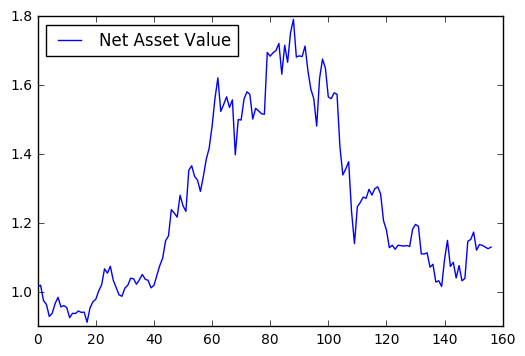

In [7]:
# simple_pa(pnl)
pmfc = (cagr(pnl), vol(pnl), sharpe_ratio(pnl), max_drawdown(pnl), drawdown_length(pnl))
print('CAGR:%f \nVolatility:%f\nPeriodical_Sharpe_ratio:%f\nMax drawdown: %f\nDrawdown length: %d\n' % pmfc)

nowstr = datetime.now().strftime('%Y%m%d_%H:%M:%S')
pnl['cumpnl'] = np.cumsum(pnl['pnl'])
plot_nav(pnl)

# pnl.to_csv('./output/pnl_series_' + nowstr + '.csv', index=False)
# plot_nav(pnl, savedir = './output/')

CAGR:		0.0485
Volatility:	0.2627
Sharpe_ratio:	0.1803
Max drawdown:	-0.1056
Drawdown length: 20


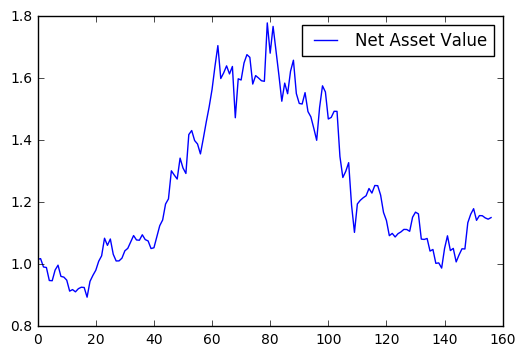

In [8]:
# Result
pnl = pd.read_csv('./output/monthly rebalance pnl.csv')
pnl.date = pd.to_datetime(pnl.date, format='%Y-%m-%d')
pnl = pnl[(pnl.date >= dstart) & (pnl.date <= dend)]
pnl.index = range(pnl.shape[0])

pmfc = (cagr(pnl),\
        vol(pnl),\
        sharpe_ratio(pnl),\
        max_drawdown(pnl),\
        drawdown_length(pnl))
print('CAGR:\t\t%.4f\n'\
        'Volatility:\t%.4f\n'\
        'Sharpe_ratio:\t%.4f\n'\
        'Max drawdown:\t%.4f\n'\
        'Drawdown length: %d' % pmfc)

plot_nav(pnl)